# Checking bias classifying facial emotions: models trained on imagenet

Explaining worker .....

In [3]:
"""
    Requirements to execute code
"""

! python3 -m pip install nltk
! python3 -m pip install mtcnn
# ! python3 -m pip install cv2
! python3 -m pip install keras
! python3 -m pip install numpy
! python3 -m pip install pandas
# ! python3 -m pip install cv2
! python3 -m pip install regex


Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.5/dist-packages/nltk-3.4.5.dist-info'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.2, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/67/43/abee91792797c609c1bf30f1112117f7a87a713ebaa6ec5201d5555a73ef/mtcnn-0.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/59/dc/f4a3c35673512e3bfaa48c4e3b6c1bc3e262a8a2bfc9ffef986780d15ad3/opencv_python-4.1.2.30-cp35-cp35m-manylinux1_x86_64.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.5/dist-packages/cv2'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.2, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import os
# import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']  = (10, 8)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [7]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 10)

## Classifying facial emotions 

In [ ]:
"""
    Importing Pre-Trained  face recognition model.
    Font article : https://github.com/atulapra/Emotion-detection/blob/master/ResearchPaper.pdf
"""

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Import values for model
model.load_weights('model/model.h5')   

# Folder of faces images
path = 'fairface-img-margin125-trainval/train/'

# List of faces images
images_list = os.listdir(path)

# List of Classifiable Emotions
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Dictionary for save results
dictResult = {}
resultImage = {}
i = 0

# Process list of face images
for file in images_list:
    nameFile = path+file
    # Warning execution
    if i % 1000 == 0:
        print("{}/{}- file:{}".format(i,len(images_list),nameFile))
    
    # Converting image to numeric array
    face_image  = cv2.imread(nameFile)
    face_image = cv2.resize(face_image, (48,48))
    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
    
    # Predtion for face image
    predicted_class = np.argmax(model.predict(face_image))
    predicted_label = emotion_dict [predicted_class]
    
    # Save result of prediction
    if predicted_label in dictResult:
        dictResult[predicted_label] += 1
    else:
        dictResult.update({predicted_label: 1})
        
    resultImage.update({file: predicted_label})
    
    i += 1

# ALL: {'Angry': 9376, 'Sad': 17019, 'Happy': 24401, 'Fear': 22127, 'Disgust': 39, 'Neutral': 8428, 'Surprise': 5354}
# 1000 : {'Angry': 109, 'Sad': 217, 'Happy': 274, 'Fear': 246, 'Disgust': 1, 'Neutral': 90, 'Surprise': 63}

### Exporting results

In [ ]:
# Dataframe of labels
df = pd.read_csv('label/fairface_label_train.csv')
df.loc[:,"file"] = [x.replace('train/',"") for x in df.loc[:,"file"]]

data = {'file':list(resultImage.keys()), 'emotions':list(resultImage.values())}

# Dataframe of result
df_result = pd.DataFrame(data=data, columns=['file', 'emotions'])

# Join two files
df = pd.merge(df_result, df, how="outer", on="file")
df.head(5)

In [ ]:
# Saves result to your used later
df.to_csv('label/emotions-fairface.csv')

## Exploratory Data Analisys

### Importing and merging data frames

In [10]:
# Importing result images classification 
df = pd.read_csv('label/emotions-fairface.csv', index_col=0)
df.head(5)

,file,emotions,age,gender,race,service_test
0,1.jpg,Angry,50-59,Male,East Asian,True
1,10.jpg,Sad,30-39,Male,Middle Eastern,False
2,100.jpg,Happy,20-29,Female,East Asian,False
3,1000.jpg,Fear,30-39,Male,White,False
4,10000.jpg,Happy,50-59,Male,White,False


### Function for merge columns categories

In [11]:
def mergeForPlot(df, colName):
    # Define labels for aixes X
    emotions_list = list(df['emotions'].unique())

    # Set of ages
    labels = list(set(df[colName]))
    labels.sort()
    
    # Define empty dataframe
    df_merge = pd.DataFrame({})

    for label in labels:

        # Group for colums 
        exp = colName+' == "'+label +'"'
        data = df.query(exp)
        data = data[["emotions","count"]]
        data.columns = ["emotions","count "+label]

        if df_merge.shape[0] == 0:
            df_merge = data
        else:
            df_merge = pd.merge(df_merge,data, on="emotions", how ="outer")
    
    return df_merge

### Population Measures

#### Gender

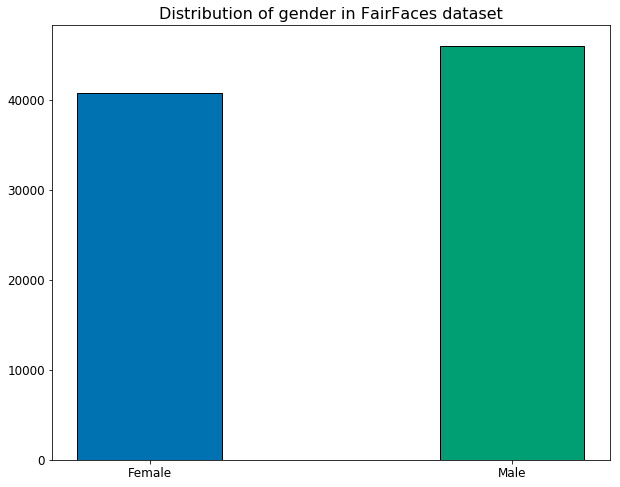

In [12]:
# Count gender in FairFaces Dataset
faces_gender = df[['gender',"file"]]
faces_gender = faces_gender.groupby("gender",as_index=False).count()

# Values
names = faces_gender.iloc[0:2,:1].values.T[0]
values = faces_gender.iloc[:,-1:].values.T[0]

# Ploting chart
bar_plot = plt.bar(names, values,  width = 0.40, color=['#0072b2','#009e73'], edgecolor='k', align = 'center')
plt.title("Distribution of gender in FairFaces dataset")
plt.show()

#### Race

{'values': array([12233, 12287, 12319, 13367,  9216, 10795, 16527])}
{'names': array(['Black', 'East Asian', 'Indian', 'Latino_Hispanic',
       'Middle Eastern', 'Southeast Asian', 'White'], dtype=object)}
<BarContainer object of 7 artists>


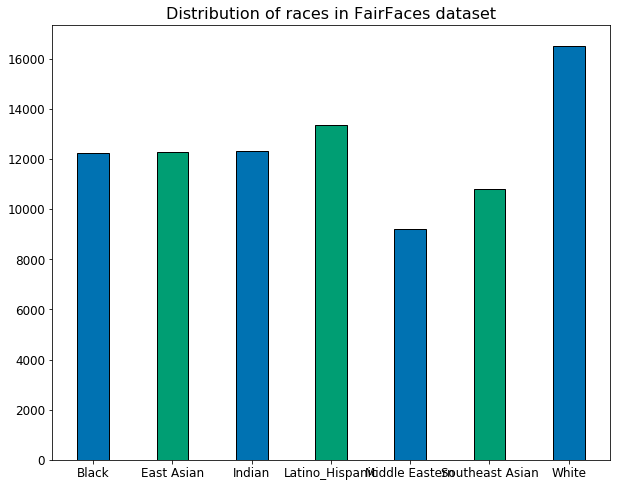

In [13]:
# Count gender in FairFaces Dataset
faces_race = df[['race',"file"]]
faces_race = faces_race.groupby("race",as_index=False).count()

# Values
names = faces_race.iloc[:,0].values
values = faces_race.iloc[:,1].values

b = {names[i]:values[i] for i in range(len(names))}
c = {'values':values}
d = {'names':names}
#a = pd.DataFrame(data=c)
print(c)
print(d)

# Ploting chart
bar_plot = plt.bar(names, values,  width = 0.40, color=['#0072b2','#009e73'], edgecolor='k', align = 'center')
#plt.set_xticklabels(names)
plt.set_rotation = "horizontal"
print(bar_plot)
plt.title("Distribution of races in FairFaces dataset")
plt.show()

#### Age

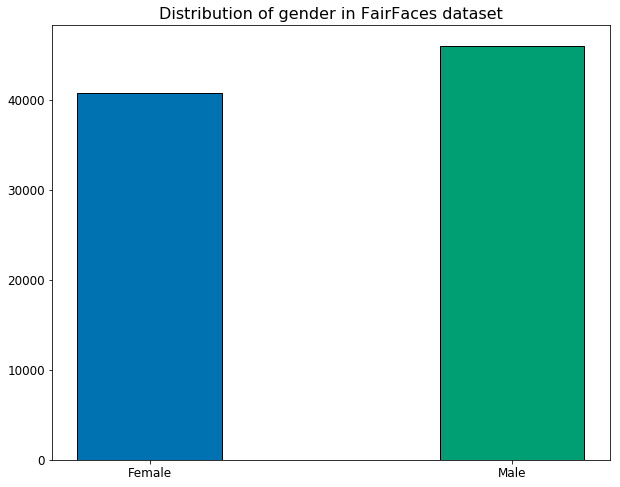

In [14]:
# Count gender in FairFaces Dataset
faces_age = df[['gender',"file"]]
faces_age = faces_gender.groupby("gender",as_index=False).count()

# Values
names = faces_gender.iloc[0:2,:1].values.T[0]
values = faces_gender.iloc[:,-1:].values.T[0]

# Ploting chart
bar_plot = plt.bar(names, values,  width = 0.40, color=['#0072b2','#009e73'], edgecolor='k', align = 'center')
plt.title("Distribution of gender in FairFaces dataset")
plt.show()

### Emotions Measures

#### Emotions for gender

In [15]:
df_gender = df.groupby(["emotions", "gender"], as_index=False).sum()
df_gender.columns = ["emotions", "gender", "count"]

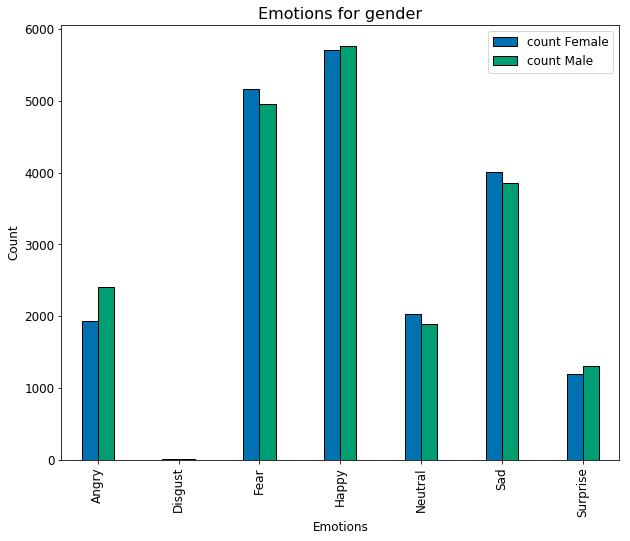

In [16]:
emotions_list = list(df_gender['emotions'].unique())

df_merge = mergeForPlot(df_gender,'gender')
plotResult = df_merge.plot.bar(
    width = 0.40, 
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for gender",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for races

In [17]:
df_race = df.groupby(["emotions", "race"], as_index=False).sum()
df_race.columns = ["emotions", "race", "count"]

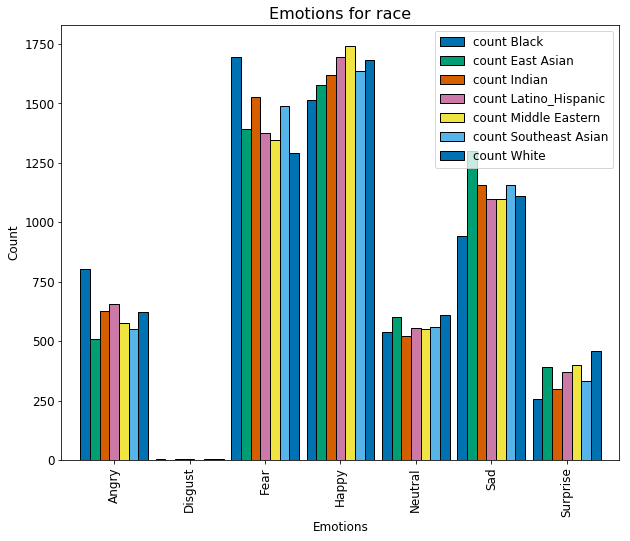

In [18]:
emotions_list = list(df_race['emotions'].unique())

df_merge = mergeForPlot(df_race,'race')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for race",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age

In [19]:
df_age = df.groupby(["emotions", "age"], as_index=False).sum()
df_age.columns = ["emotions", "age", "count"]

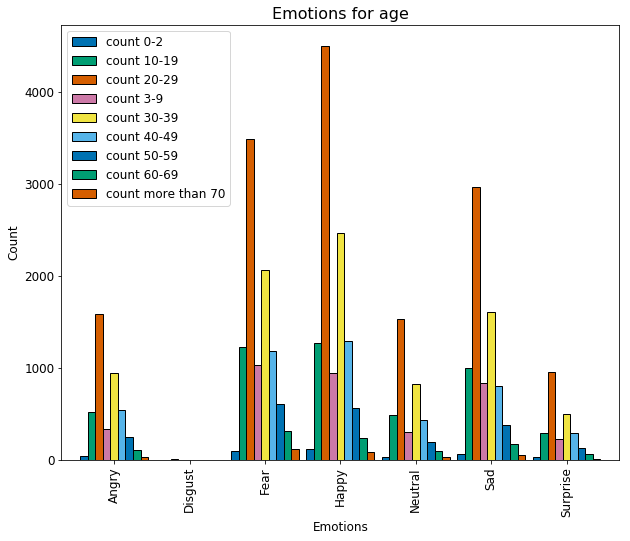

In [20]:
emotions_list = list(df_age['emotions'].unique())

df_merge = mergeForPlot(df_age,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age and gender

In [21]:
df_age_gender = df.groupby(["emotions", "age", "gender"], as_index=False).sum()
df_age_gender.columns = ["emotions", "age", "gender","count"]

##### Gender: male

In [22]:
df_male = df_age_gender.query("gender == 'Male'")
df_female = df_age_gender.query("gender == 'Female'")

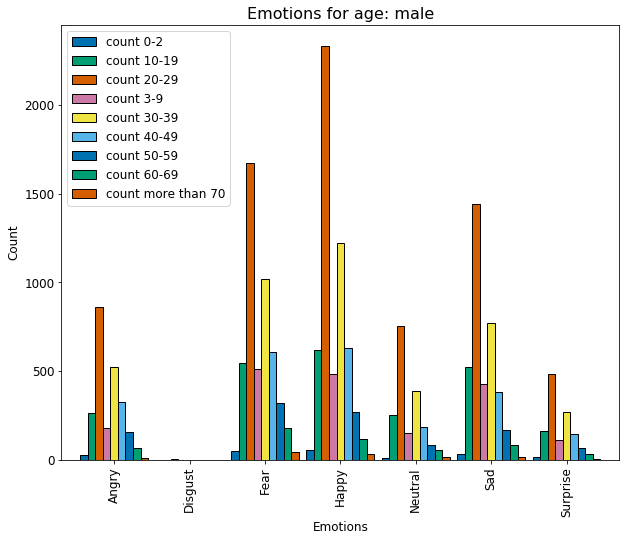

In [23]:
emotions_list = list(df_male['emotions'].unique())

df_merge = mergeForPlot(df_male,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age: male",
    xlabel='Emotions',
    ylabel="Count"
)

##### Gender: female

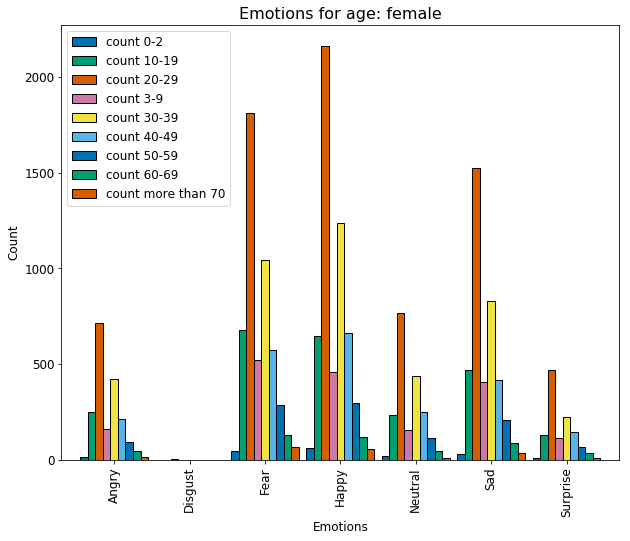

In [24]:
emotions_list = list(df_female['emotions'].unique())

df_merge = mergeForPlot(df_female,'age')
plotResult = df_merge.plot.bar(
    width = 0.90,
    edgecolor='k'
).set(
    xticklabels=emotions_list,
    title="Emotions for age: female",
    xlabel='Emotions',
    ylabel="Count"
)

#### Emotions for age and race

In [25]:
df_age_race = df.groupby(["emotions", "age", "race"], as_index=False).sum()
df_age_race.columns = ["emotions", "age", "race","count"]

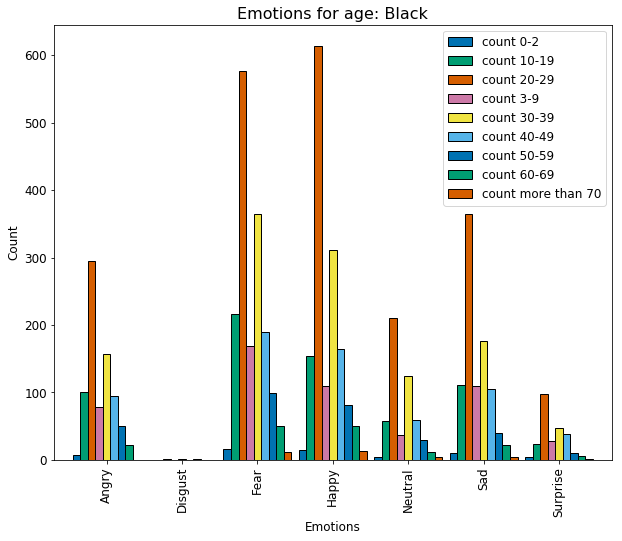

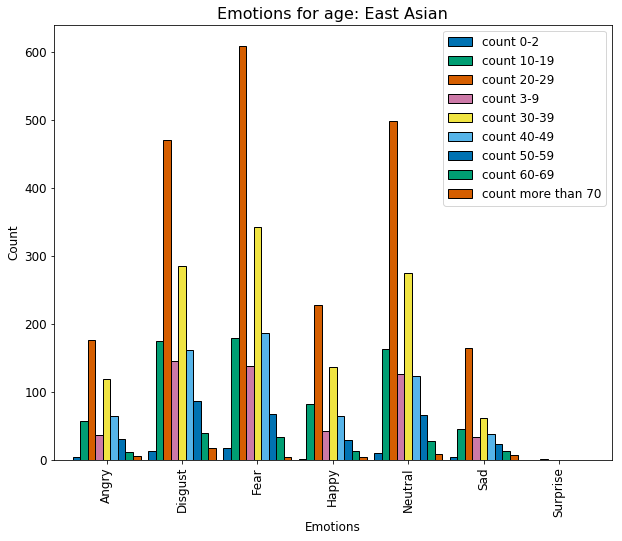

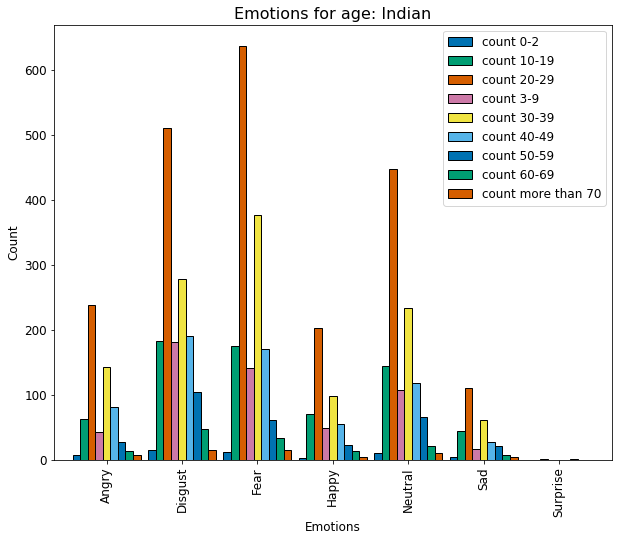

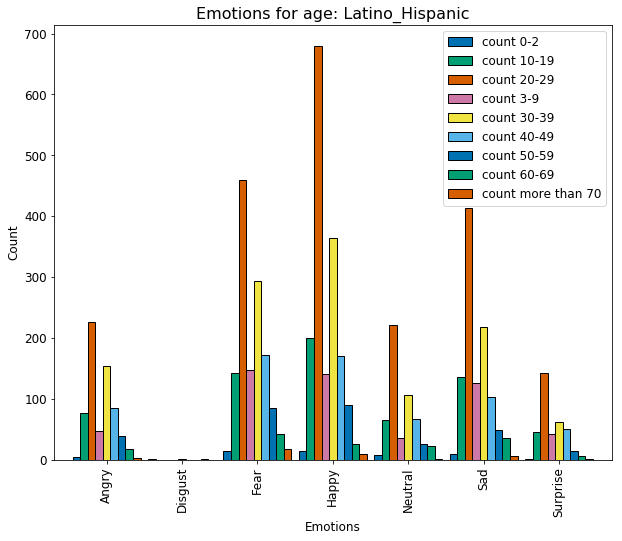

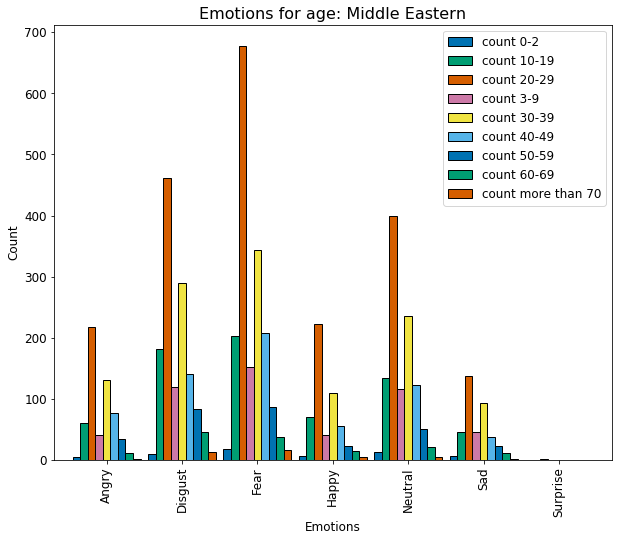

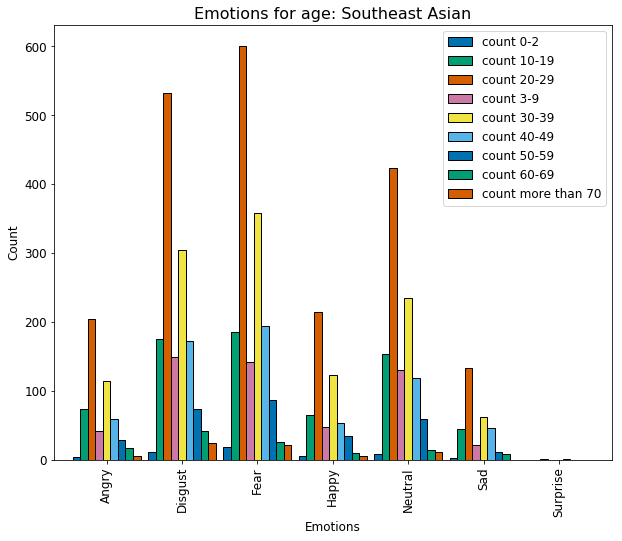

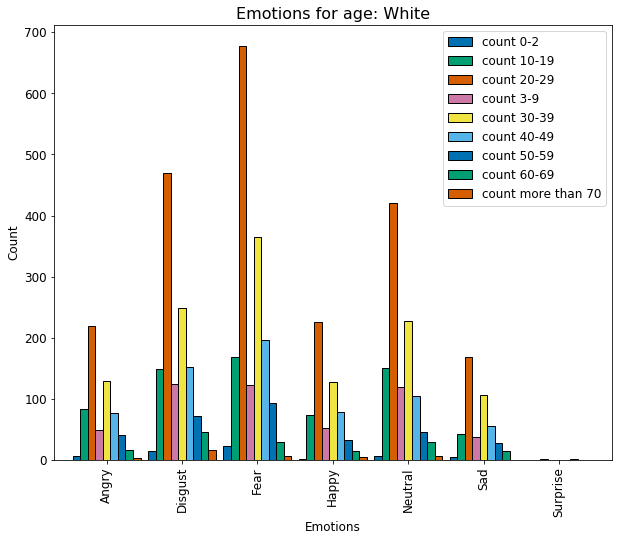

In [26]:
emotions_list = list(df_age_race['emotions'].unique())
races_list = list(df_age_race['race'].unique())

for race in races_list:
    exp = "race =='"+race+"'"
    
    a = df_age_race.query(exp)
    #display(a.groupby(["emotions","age", "race"], as_index=False).sum())
    #display(a.groupby(["emotions", "race"], as_index=False).sum())
    
    df_merge = mergeForPlot(df_age_race.query(exp),'age')
    plotResult = df_merge.plot.bar(
        width = 0.90,
        edgecolor='k'
    ).set(
        xticklabels=emotions_list,
        title="Emotions for age: "+race,
        xlabel='Emotions',
        ylabel="Count"
    )
    
    plt.show()
    df_merge = None

#### Emotions for age, race and gender

In [27]:
df_age_race_gender = df.groupby(["emotions", "age", "race","gender"], as_index=False).sum()
df_age_race_gender.columns = ["emotions", "age", "race","gender","count"]

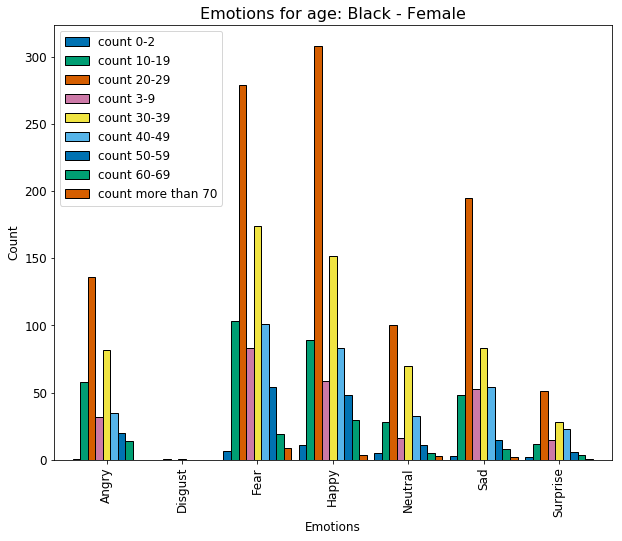

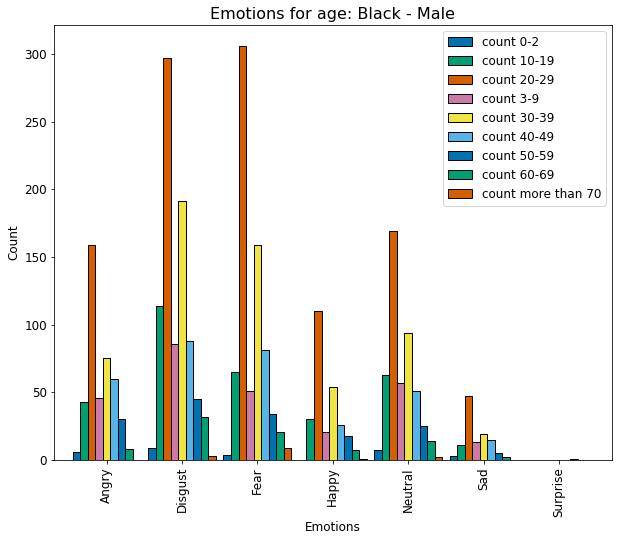

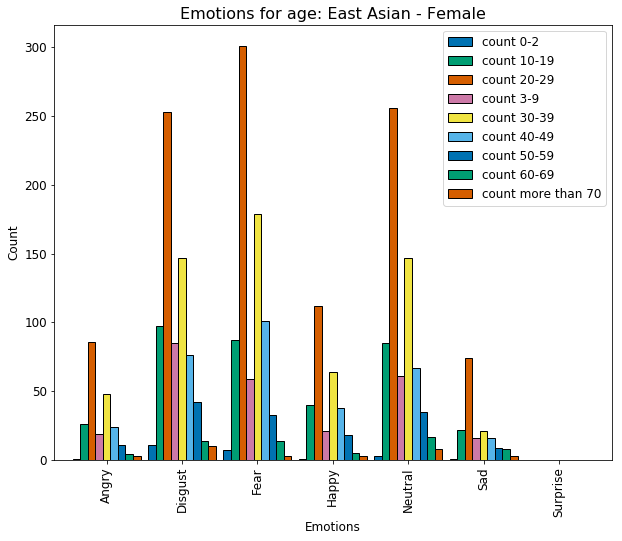

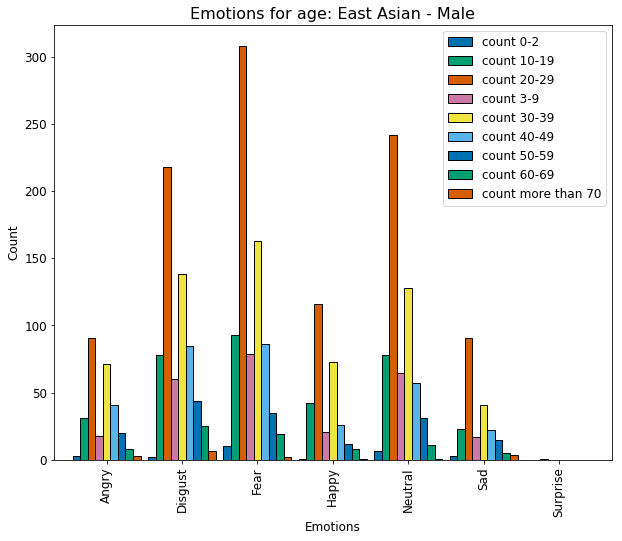

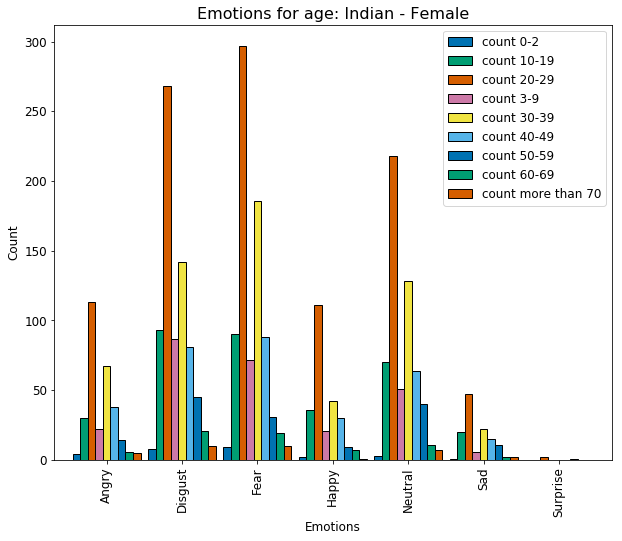

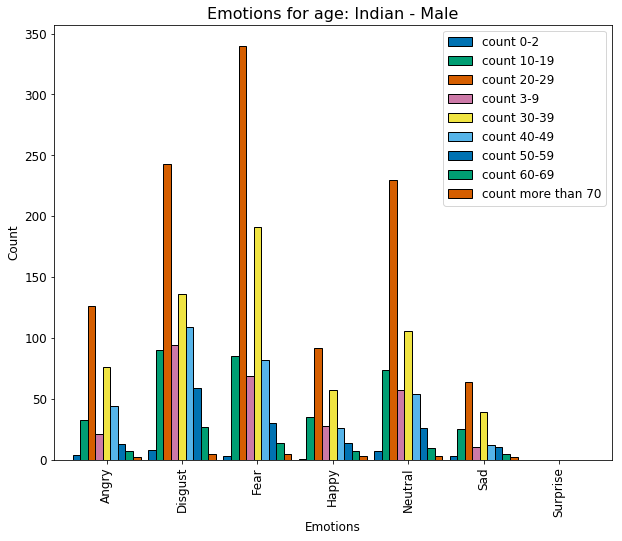

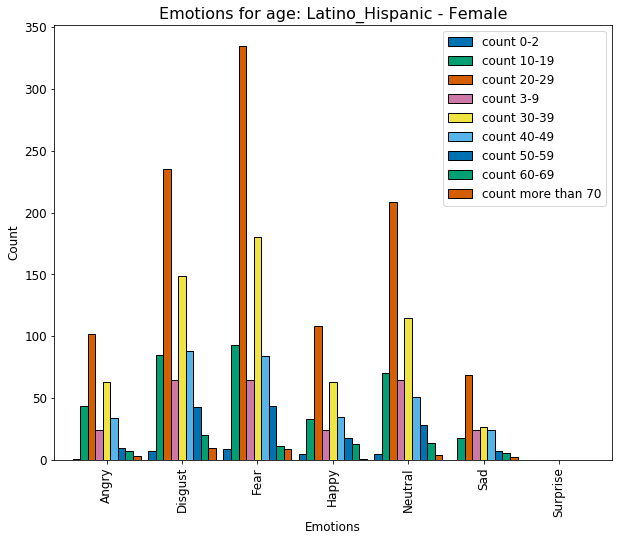

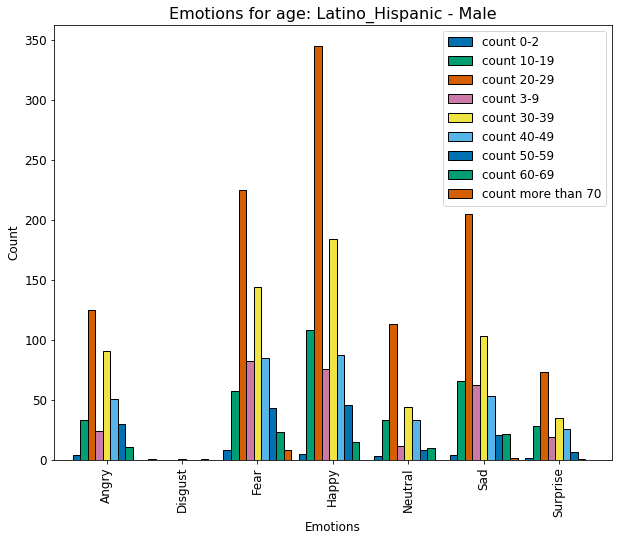

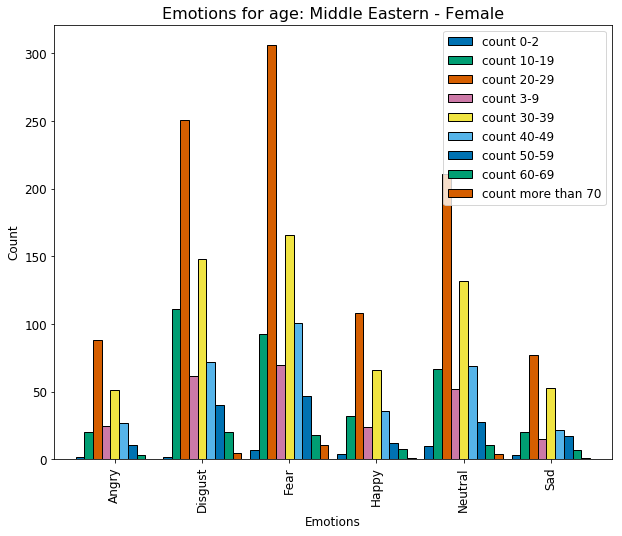

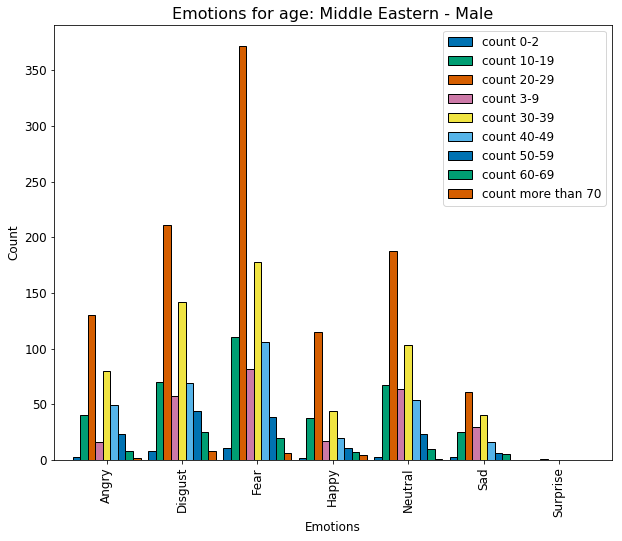

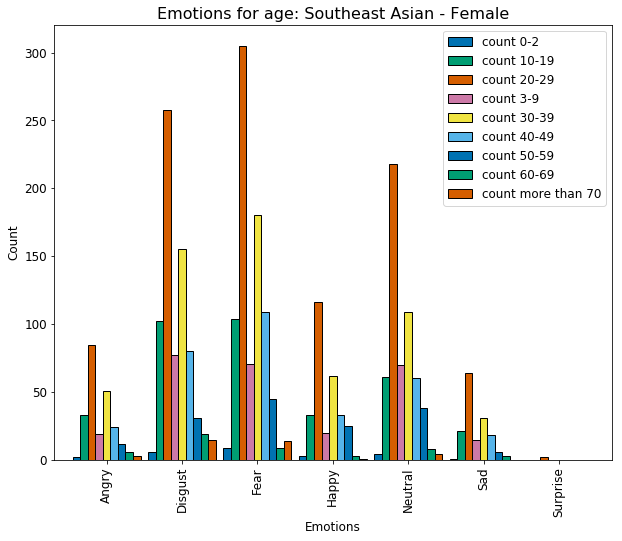

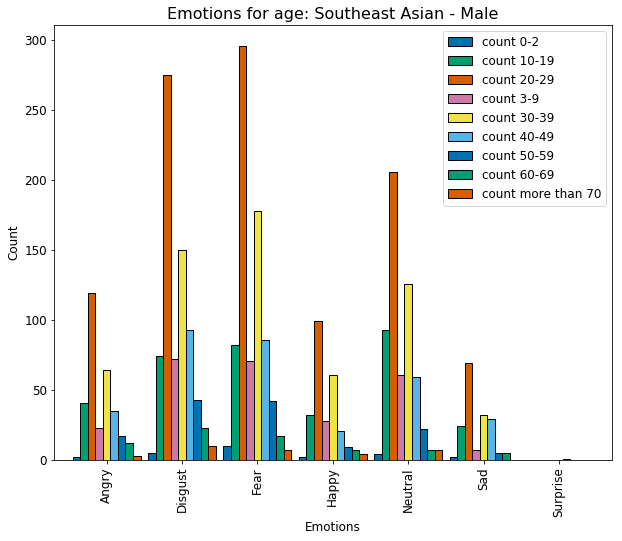

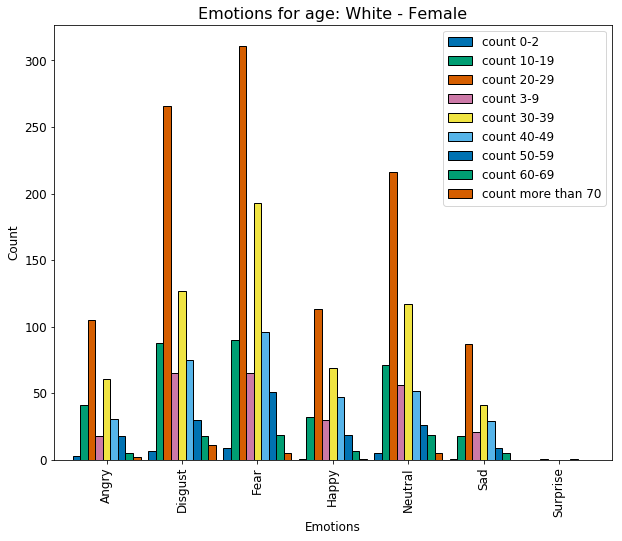

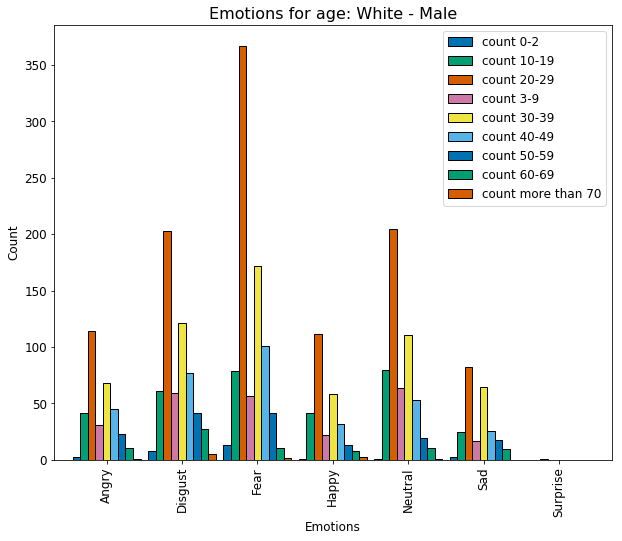

In [28]:
emotions_list = list(df_age_race_gender['emotions'].unique())
races_list = list(df_age_race_gender['race'].unique())
gender_list = list(df_age_race_gender['gender'].unique())

for race in races_list:
    for gender in gender_list:
        
        exp1 = "race =='"+race+"'"
        exp2 = "gender =='"+gender+"'"
        
        df_merge = mergeForPlot(df_age_race_gender.query(exp1).query(exp2),'age')
        plotResult = df_merge.plot.bar(
            width = 0.90,
            edgecolor='k'
        ).set(
            xticklabels=emotions_list,
            title="Emotions for age: "+race+" - "+gender,
            xlabel='Emotions',
            ylabel="Count"
        )
        
        plt.show()
        df_merge = None

## Confidence Interval

In [29]:
df_gender_col = mergeForPlot(df_gender,'gender')
df_gender_col

,emotions,count Female,count Male
0,Angry,1933.0,2413.0
1,Disgust,9.0,8.0
2,Fear,5162.0,4950.0
3,Happy,5704.0,5767.0
4,Neutral,2038.0,1898.0
5,Sad,4016.0,3850.0
6,Surprise,1200.0,1304.0


In [30]:
# Define numerical columns
numer_columns = [
    'count Female',
    'count Male'
]

# Calc score z of columns
mean = df_gender_col.mean()
std = df_gender_col.std(ddof=1)
df_gender_col[numer_columns] = (df_gender_col[numer_columns] - mean[numer_columns]) /(std[numer_columns])
df_gender_col.head(5)

,emotions,count Female,count Male
0,Angry,-0.438665,-0.228719
1,Disgust,-1.343264,-1.395888
2,Fear,1.079501,1.002510
3,Happy,1.334331,1.399007
4,Neutral,-0.389297,-0.478653


In [31]:
df_gender_col["diff Gender"] = abs(df_gender_col["count Female"] - df_gender_col["count Male"])
df_gender_col

,emotions,count Female,count Male,diff Gender
0,Angry,-0.438665,-0.228719,0.209946
1,Disgust,-1.343264,-1.395888,0.052623
2,Fear,1.079501,1.002510,0.076991
3,Happy,1.334331,1.399007,0.064676
4,Neutral,-0.389297,-0.478653,0.089356
5,Sad,0.540691,0.468670,0.072021
6,Surprise,-0.783297,-0.766927,0.016370


In [32]:
df.groupby("gender",as_index=False).count()

,gender,file,emotions,age,race,service_test
0,Female,40758,40758,40758,40758,40758
1,Male,45986,45986,45986,45986,45986


# Calculating confidence intervals

Probability of probabilities

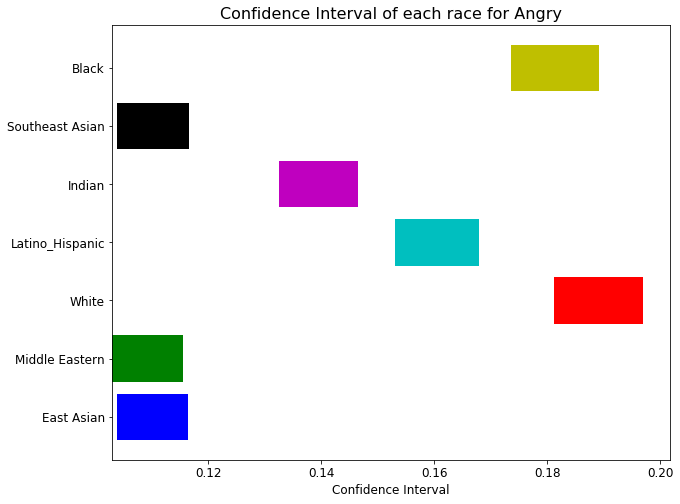

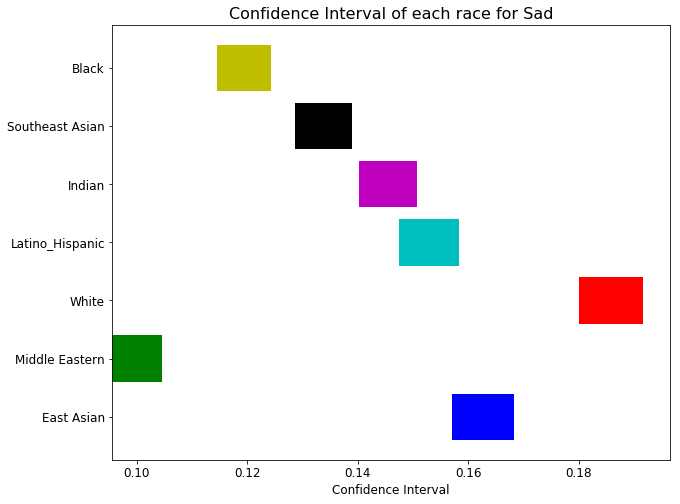

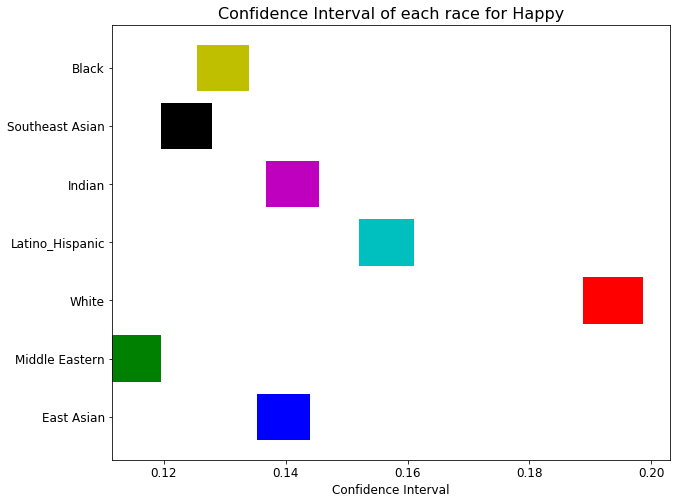

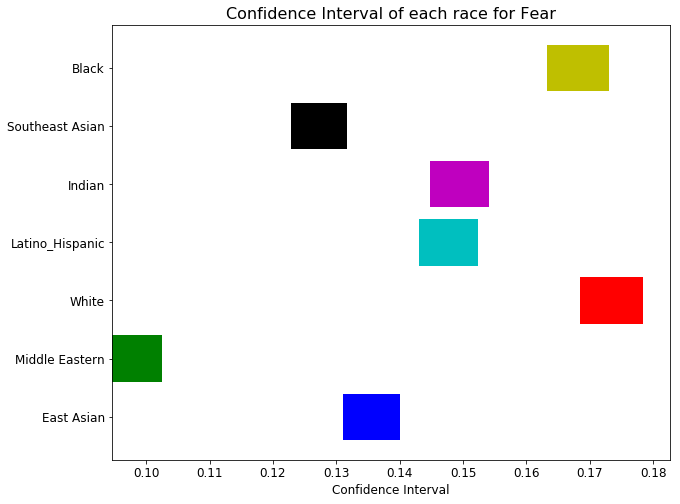

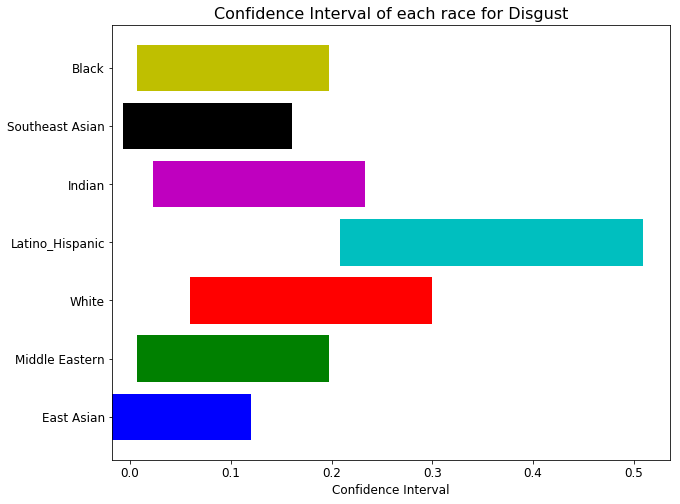

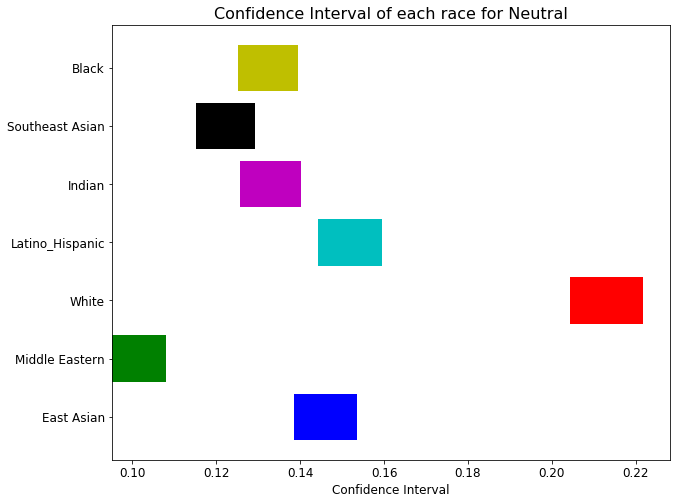

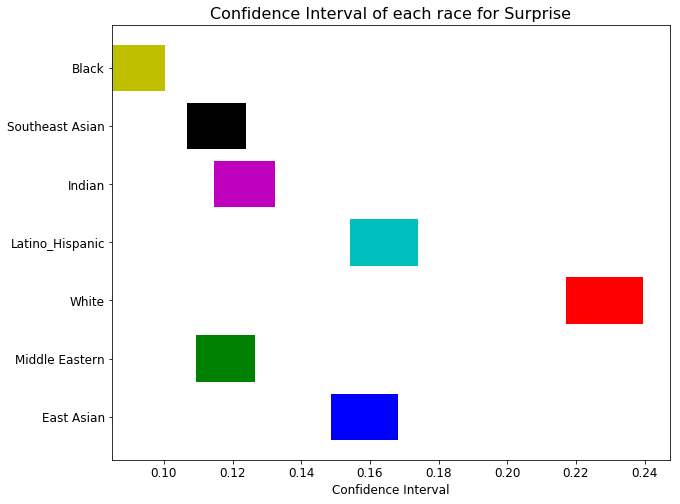

In [76]:
emotions = df['emotions'].unique()
races = df['race'].unique()

for emo in emotions:
    confidence_intervals = {}
    #for plotting
    bar_start = []
    bar_end = []
    
    n = len(df[df['emotions'] == emo])
    for race in races:
        
        p = len(df[(df['emotions'] == emo) & (df['race'] == race)])
        p = p/n
        
        #using formula for calculating confidence intervals with
        #discrete variables, using the Adjusted Wald technique
        c_interval = np.zeros(2)
        offset = 1.96*(np.sqrt(p*(1-p)/n))
        c_interval[1] = p + offset
        c_interval[0] = p - offset
        confidence_intervals[race] = c_interval
        
        #for plotting
        bar_start.append(c_interval[0])
        bar_end.append(c_interval[1] - c_interval[0])
        
        
    #ploting confidence intervals for each race, fixing emotions
    fig, ax = plt.subplots()
    y_pos = np.arange(len(races))
    colors = ['b', 'g', 'r', 'c', 'm', 'k', 'y']
    
    ax.barh(y_pos, bar_end, 0.8, bar_start, color=colors)
    plt.yticks(y_pos, races)
    ax.set_xlabel('Confidence Interval')
    ax.set_title('Confidence Interval of each race for {}'.format(emo))
    
    plt.show()